# Gaussian blur with Numba

Let's try doing something a little more complex. Let's take an image and use our GPU to apply a gaussian blur.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from numba import cuda
import numpy as np
import math

plt.rcParams["figure.figsize"] = (30,4)


## Data loading

After we import the tools we will need we can read in an image file as a numpy array. Let's use the Numba logo.

In [2]:
im = plt.imread("./images/numba.png")

In [3]:
type(im)


numpy.ndarray

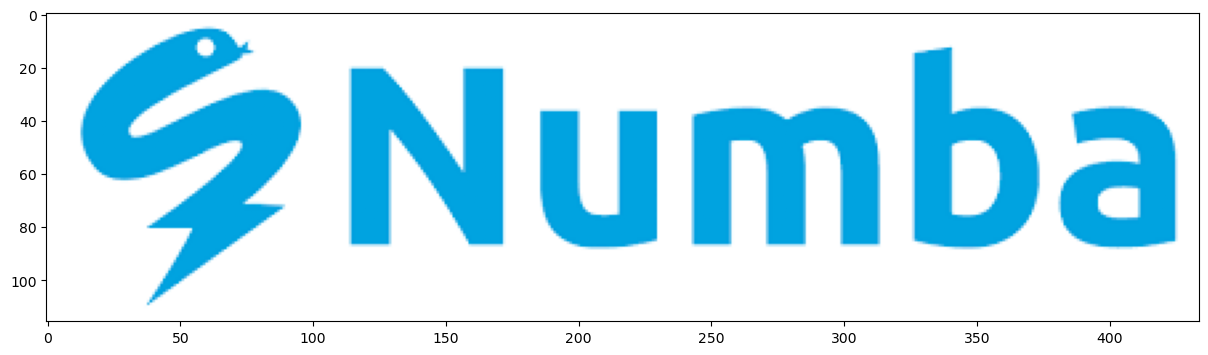

In [4]:
plt.imshow(im)


Next let's move the image to the GPU and also create an output array for us to blur our image into.

In [6]:
gpu_im = cuda.to_device(im)
gpu_output = cuda.to_device(np.zeros_like(gpu_im))


## Multi-dimensional indexing

Before we write our blur function let's talk about multi-dimensional indexing. In our previous example we used `cuda.grid(1)` to get our `i` value. The `1` in this call refers to the number of dimensions this index should have. We were working with 1-dimensional array to it made sense to have a 1-dimensional index.

But now we are working with an image which has three dimensions, two for `x` and `x` and one for `channel` (red, green, blue, alpha).

In [7]:
im.shape


(116, 434, 4)

We want our CUDA kernel to operate on every pixel in this image. We could continue to use `i`, ensure `i` is `116 * 434 * 4` and unwrap our index ourselves to work out pixel we want to work with.

But instead we can use three-dimensional indexing here so that instead of `i` we can have `x`, `y` and `channel` indices.

First off we need to specify a three dimensional thread size. Let's continue using a threadsize of `128` but we can specify this as three numbers which multiply to be `128`.

In [8]:
# threadsperblock = 128
threadsperblock = (2, 16, 4)


Next we need to calculate our blocksize. We will use the dimensions of our image to calculate how many threads we would need to cover our image.

In [ ]:
blockspergrid_x = math.ceil(gpu_im.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(gpu_im.shape[1] / threadsperblock[1])
blockspergrid_z = math.ceil(gpu_im.shape[2] / threadsperblock[2])
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)


In [ ]:
blockspergrid


If we multiply our threads and blocks together we can see that we have a grid that is slightly larger than our image.

In [ ]:
[t*b for t, b in zip(threadsperblock, blockspergrid)]


## Writing our blur kernel

Our kernel needs to take in the image and the output array.

It needs to get the grid position to operate on and then perform the blur on the image in that position.

We only care about blurring across the `x` and `y` dimensions, not accross the colours. So we will just pass the `c` value straight through.

In [ ]:
@cuda.jit
def blur(im, output):
    # With our three-dimensional grid we can get our index position in three dimensions
    x, y, c = cuda.grid(3)

    # Because our grid is slightly larger than our image anything outside the image should be ignored
    if x < im.shape[0] and y < im.shape[1] and c < im.shape[2]:

        # Set the output array pixel to the average of the nine pixels around that point on the input array
        output[x, y, c] = (im[x-1, y-1, c] + im[x, y-1, c] + im[x+1, y-1, c]  + \
                           im[x-1, y, c]   + im[x, y, c]   + im[x+1, y, c]    + \
                           im[x-1, y+1, c] + im[x+1, y, c] + im[x+1, y+1, c]) / 9


## Running our kernel

Now let's run our kernel a number of times to get our desired level of blur.

We need each pass to complete before starting the next one. We also need our output to become our input, and we need a new output to work into. We can reuse the old input as our new output array, this is efficient because we can just reuse both existing arrays on the GPU.

This is where manual memory management comes in handy, we can call our kernel many times but leave all the data on the GPU. We just swap pointers around between each pass.

In [ ]:
for i in range(5):
    blur[blockspergrid, threadsperblock](gpu_im, gpu_output)
    gpu_im, gpu_output = gpu_output, gpu_im


Now if we look at our image it should be sufficiently blurry.

In [ ]:
plt.imshow(gpu_output.copy_to_host())
